In [1]:
from transformers import BertConfig
%load_ext autoreload
%autoreload 2

In [2]:
from bert_lstm_fe import *

In [3]:
# Use GPU
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print("Available device: {}".format(device))
if use_cuda:
    print(torch.cuda.get_device_name(0))

Available device: cuda:0
NVIDIA GeForce GTX 1070


In [4]:
sample_column_name = "string"
columns_to_keep = ['string', 'label', 'citeStart', 'citeEnd']

train_dataset_file_path = "../../data/raw/train.jsonl"
test_dataset_file_path = "../../data/raw/test.jsonl"

label_to_index = {
    "background": 0,
    "method": 1,
    "result": 2
}

# Load dataset
df_train = load_dataset_raw(train_dataset_file_path, sample_column=sample_column_name, columns_to_keep=columns_to_keep)
df_test = load_dataset_raw(test_dataset_file_path, sample_column=sample_column_name, columns_to_keep=columns_to_keep)

# {'background': 0, 'method': 1, 'result': 2}
unique_labels = df_train['label'].unique()

In [5]:
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_config = BertConfig.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased', config=bert_config)

bert_model = bert_model.to(device)

In [6]:
citation_token = ["<cite>"]
bert_tokenizer.add_tokens(citation_token)
bert_model.resize_token_embeddings(len(bert_tokenizer))

Embedding(30523, 768)

In [7]:
# processing the dataset
print("Processing train dataset...")
texts_train, labels_train = process_data_bert_fe(df_train, label_to_index)

print("Processing test dataset...")
texts_test, labels_test = process_data_bert_fe(df_test, label_to_index)

print('Total number of training samples: {}'.format(len(texts_train)))
print('Total number of test samples: {}'.format(len(texts_test)))

Processing train dataset...


100%|██████████| 8240/8240 [00:00<00:00, 19342.66it/s]


Processing test dataset...


100%|██████████| 1857/1857 [00:00<00:00, 17851.21it/s]

Total number of training samples: 8240
Total number of test samples: 1857


In [8]:
# tokenize dataset with bert tokenizer

max_seq_length = 128

tokens_train = bert_tokenizer.batch_encode_plus(
    texts_train,
    max_length = max_seq_length,
    padding=True,
    truncation=True
)

tokens_test = bert_tokenizer.batch_encode_plus(
    texts_test,
    max_length = max_seq_length,
    padding=True,
    truncation=True
)

In [9]:
# generate sequence, mask and labels

train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(labels_train)

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(labels_test)

In [10]:
# dataset label counts
counts = torch.bincount(train_y)
print(counts)

tensor([4840, 2293, 1107])


In [11]:
# define dataloaders

batch_size = 32

train_data = TensorDataset(train_seq, train_mask, train_y)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(test_seq, test_mask, test_y)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [12]:
for X, mask, y in train_dataloader:
    print('X.shape:', X.shape)
    print('mask.shape:', mask.shape)
    print('y.shape:', y.shape)
    break

X.shape: torch.Size([32, 128])
mask.shape: torch.Size([32, 128])
y.shape: torch.Size([32])


In [13]:
# initialize bert lstm model
bert_lstm_fe = BertLSTM_FE(bert_model)
bert_lstm_fe = bert_lstm_fe.to(device)

print(bert_lstm_fe)

BertLSTM_FE(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30523, 768)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
       

In [14]:
class_weights = torch.tensor([1 / counts[0].item(), 
                              1 / counts[1].item(), 
                              1 / counts[2].item()]).to(device)

criterion  = nn.CrossEntropyLoss(weight=class_weights) 
optimizer = torch.optim.Adam(bert_lstm_fe.parameters(), lr=0.0005)

In [15]:
num_epochs = 25

results = train(bert_lstm_fe, train_dataloader, val_dataloader, 
                optimizer, criterion, num_epochs, device, verbose=True)

Total Training Time (total number of epochs: 25)


100%|██████████| 59/59 [00:12<00:00,  4.59it/s]


saving model checkpoint to bert_lstm_fe.pth
[Epoch 1] loss:	219.917, f1 train: 0.730, f1 test: 0.755 


100%|██████████| 59/59 [00:13<00:00,  4.49it/s]


saving model checkpoint to bert_lstm_fe.pth
[Epoch 2] loss:	206.936, f1 train: 0.753, f1 test: 0.773 


100%|██████████| 59/59 [00:13<00:00,  4.42it/s]


saving model checkpoint to bert_lstm_fe.pth
[Epoch 3] loss:	188.753, f1 train: 0.786, f1 test: 0.788 


100%|██████████| 59/59 [00:13<00:00,  4.39it/s]


[Epoch 4] loss:	181.320, f1 train: 0.737, f1 test: 0.698 


100%|██████████| 59/59 [00:13<00:00,  4.41it/s]


[Epoch 5] loss:	175.852, f1 train: 0.798, f1 test: 0.785 


100%|██████████| 59/59 [00:13<00:00,  4.39it/s]


saving model checkpoint to bert_lstm_fe.pth
[Epoch 6] loss:	166.960, f1 train: 0.840, f1 test: 0.839 


100%|██████████| 59/59 [00:15<00:00,  3.73it/s]


[Epoch 7] loss:	167.081, f1 train: 0.777, f1 test: 0.775 


100%|██████████| 59/59 [00:13<00:00,  4.38it/s]


[Epoch 8] loss:	162.640, f1 train: 0.806, f1 test: 0.783 


100%|██████████| 59/59 [00:13<00:00,  4.27it/s]


[Epoch 9] loss:	163.039, f1 train: 0.837, f1 test: 0.804 


100%|██████████| 59/59 [00:13<00:00,  4.27it/s]


[Epoch 10] loss:	157.117, f1 train: 0.846, f1 test: 0.822 


100%|██████████| 59/59 [00:13<00:00,  4.37it/s]


[Epoch 11] loss:	153.798, f1 train: 0.855, f1 test: 0.819 


100%|██████████| 59/59 [00:13<00:00,  4.35it/s]


[Epoch 12] loss:	149.914, f1 train: 0.863, f1 test: 0.805 


100%|██████████| 59/59 [00:13<00:00,  4.27it/s]


[Epoch 13] loss:	149.923, f1 train: 0.869, f1 test: 0.829 


100%|██████████| 59/59 [00:13<00:00,  4.29it/s]


[Epoch 14] loss:	143.313, f1 train: 0.851, f1 test: 0.781 


100%|██████████| 59/59 [00:13<00:00,  4.29it/s]


[Epoch 15] loss:	144.955, f1 train: 0.894, f1 test: 0.831 


100%|██████████| 59/59 [00:13<00:00,  4.31it/s]


[Epoch 16] loss:	137.117, f1 train: 0.896, f1 test: 0.829 


100%|██████████| 59/59 [00:14<00:00,  4.09it/s]


[Epoch 17] loss:	133.497, f1 train: 0.887, f1 test: 0.819 


100%|██████████| 59/59 [00:15<00:00,  3.77it/s]


[Epoch 18] loss:	133.734, f1 train: 0.900, f1 test: 0.810 


100%|██████████| 59/59 [00:15<00:00,  3.80it/s]


[Epoch 19] loss:	126.285, f1 train: 0.914, f1 test: 0.821 


100%|██████████| 59/59 [00:15<00:00,  3.80it/s]


[Epoch 20] loss:	126.947, f1 train: 0.944, f1 test: 0.815 


100%|██████████| 59/59 [00:14<00:00,  3.93it/s]


[Epoch 21] loss:	125.802, f1 train: 0.922, f1 test: 0.811 


100%|██████████| 59/59 [00:13<00:00,  4.47it/s]


[Epoch 22] loss:	121.026, f1 train: 0.946, f1 test: 0.805 


100%|██████████| 59/59 [00:13<00:00,  4.32it/s]


[Epoch 23] loss:	117.010, f1 train: 0.933, f1 test: 0.799 


100%|██████████| 59/59 [00:13<00:00,  4.33it/s]


[Epoch 24] loss:	118.283, f1 train: 0.924, f1 test: 0.794 


100%|██████████| 59/59 [00:13<00:00,  4.47it/s]

[Epoch 25] loss:	111.692, f1 train: 0.928, f1 test: 0.796 


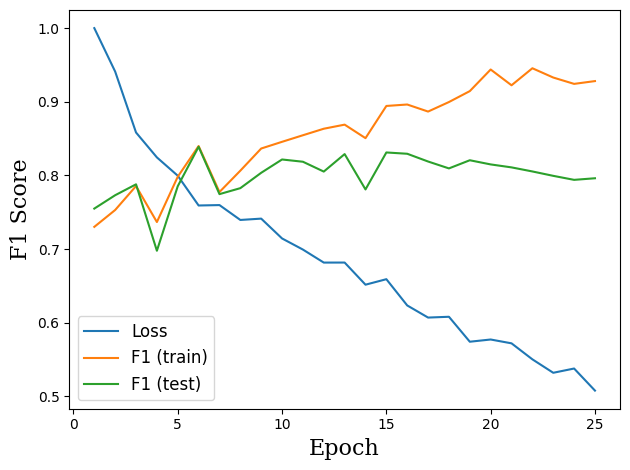

In [16]:
plot_training_results(results)

100%|██████████| 59/59 [00:13<00:00,  4.49it/s]

Evaluating model: bert_lstm_fe_839.pth
F1 score for model: 0.839


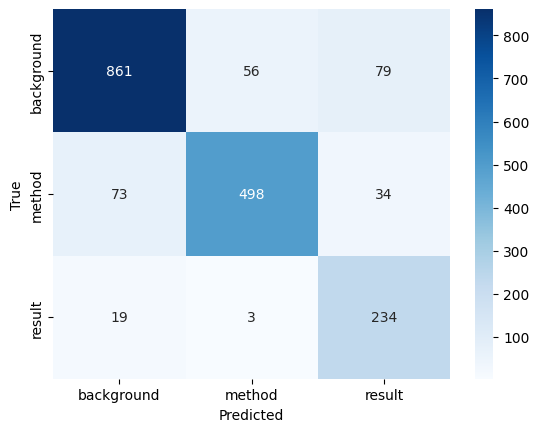

              precision    recall  f1-score   support

  background       0.90      0.86      0.88       996
      method       0.89      0.82      0.86       605
      result       0.67      0.91      0.78       256

    accuracy                           0.86      1857
   macro avg       0.82      0.87      0.84      1857
weighted avg       0.87      0.86      0.86      1857


In [18]:
model_path = 'bert_lstm_fe_839.pth'

eval_model = torch.load(model_path)

y_true, y_pred = evaluate(eval_model, val_dataloader, device, is_f1=False)
label_list = ['background', 'method', 'result']

f1_eval = f1_score(y_true, y_pred, average='macro')
cm_eval = confusion_matrix(y_true, y_pred)
report = classification_report(y_true, y_pred, target_names=label_list)

print('Evaluating model: {}'.format(model_path))
print('F1 score for model: {:.3f}'.format(f1_eval))

sns.heatmap(cm_eval, annot=True, fmt='d', cmap='Blues', xticklabels=label_list, yticklabels=label_list)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print(report)